In [1]:
%matplotlib inline
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate, displace
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt
from qutip import sprepost, spre, spost

#import UD_liouv as RC
#import driving_liouv as EM
import scipy as sp

#import phonon_weak_coupling as WC
#from utils import beta_f, J_underdamped, J_minimal_hard, J_multipolar, J_poly
#from utils Occupation
import pickle
from sympy import coth


In [2]:
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
plt.rc('grid', linestyle="--", color='grey')
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.3
plt.rcParams['lines.linewidth'] = 2.3
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 19
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']


colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
colors+=colours
colors+=['#8279b8'] 

In [3]:
def load_obj(name ):
    with open(name + '.pickle', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name ):
    with open(name + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Default parameters

In [4]:
ev_to_inv_cm = 8065.5
#inv_ps_to_inv_cm = 33.356227807
inv_ps_to_inv_cm = 5.309

G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.

epsilon = 2. * ev_to_inv_cm
w0= 50e-3 * ev_to_inv_cm
Gamma = 10e-3 * ev_to_inv_cm
lifetime = 100. #ps
Gamma_EM = (1/lifetime)*inv_ps_to_inv_cm

timelist = np.linspace(0, 1*1e3, 3000)/inv_ps_to_inv_cm

### Building CC model

In [5]:

def displacement(alpha_ph, w0):
    return np.sqrt(np.pi * alpha_ph * w0 / 2.)/w0

def L_residual(alpha_ph, T_ph, N):
    gamma = Gamma / (2. * np.pi * w0)  # coupling between RC and residual bath
    
    Lambda = np.sqrt(np.pi * alpha_ph * w0 / 2.)  # coupling strength between the TLS and RC
    Omega = w0
    a = destroy(N)
    shift = pi*alpha_ph/2
    I_sys = qeye(2)
    I_N = qeye(N)
    H_S = (epsilon+shift)*tensor(sigma.dag()*sigma, I_N) + Lambda*tensor(sigma.dag()*sigma, (a + a.dag())) 
    H_S +=  Omega*tensor(I_sys, a.dag()*a)
    
    S = tensor(I_sys, (a + a.dag()))
    zeta  = 0
    energies, states = H_S.eigenstates()
    dim = len(energies)
    for j in range(dim):
        for k in range(dim):
            state_k, state_j = states[k], states[j]
            pos_jk = S.matrix_element(state_j.dag(), state_k)
            if np.abs(pos_jk)> 0:
                energy_jk = energies[j]-energies[k]
                dyad_jk = state_j*state_k.dag()
                if np.abs(energy_jk)<1e-12:
                    zeta+= pi*0.695*T_ph*gamma*pos_jk*dyad_jk
                else:
                    zeta+= (pi/2)*gamma*energy_jk*(float(coth(energy_jk/(2*0.695*T_ph)))+1)*pos_jk*dyad_jk
    L_ = sprepost(S, zeta) - spost(zeta*S) + sprepost(zeta.dag(), S) - spre(S*zeta.dag())
    return H_S, L_, tensor(sigma, I_N)

In [6]:
def Occupation(omega, T):
    n =0.
    beta = 0.
    if T ==0.: # First calculate beta
        n = 0.
        beta = np.infty
    else:
        # no occupation yet, make sure it converges
        beta = 1. / (0.695*T)
        if sp.exp(omega*beta)-1 ==0.:
            n = 0.
        else:
            n = float(1./(sp.exp(omega*beta)-1))
    return n

### Additive and non-additive EM theory

In [7]:
# Additive model

def lindblad(op):
    opdop = op.dag()*op
    return 2*sprepost(op, op.dag()) - (spre(opdop) + spost(opdop))
    
def L_additive(A, T_EM):
    n = Occupation(epsilon, T_EM)
    return (Gamma_EM/2.)*((n+1)*lindblad(A) + n*lindblad(A.dag()))

def thermal_state(T_):
    th_un = ((-epsilon*E*E.dag()/(0.695*T_)).expm())
    return ((th_un/th_un.norm())*E*E.dag()).tr()

# The non-secular non-additive model
def J_EM(w, s):
    return ((w/epsilon)**s)*(Gamma_EM/(2*pi))

def rate_up(w, T, s):
    n = Occupation(w, T)
    rate = pi * n * J_EM(w, s)
    return rate

def rate_down(w, T, s):
    n = Occupation(w, T)
    rate = pi * (n + 1. ) * J_EM(w, s)
    return rate

def commutators(A, B):
    return spre(A*B) - sprepost(B, A) + spost(B.dag()*A.dag()) - sprepost(A.dag(), B.dag())

def L_optical(H, sigma_CC, T_EM, s=3, tol=1e-12):
    Xi_1 = 0
    Xi_2 = 0
    energies, states = H.eigenstates()
    dim = len(energies)
    sigma_test = 0
    for j in range(dim):
        for k in range(dim):
            energy_jk = energies[j]-energies[k]
            
            if energy_jk<-tol:
                # if energy is smaller than negative tolerance, count it as negative
                state_k, state_j = states[k], states[j]
                sigma_jk = sigma_CC.matrix_element(state_j.dag(), state_k)
                sigma_dag_kj = (sigma_CC.dag()).matrix_element(state_k.dag(), state_j)
                
                dyad_jk = state_j*state_k.dag()
                Xi_1 += sigma_jk*rate_down(abs(energy_jk), T_EM, s)*dyad_jk
                Xi_2 += sigma_dag_kj*rate_up(abs(energy_jk), T_EM, s)*dyad_jk.dag()
                
            elif abs(energy_jk)<tol: 
                # if the magnitude of the energy is smaller than numerical tolerance
                # account for the zero frequency contribution, which is zero if s>1
                if s==1:
                    zero_contribution = Gamma_EM*0.695*T_EM/(2*pi*epsilon)
                    state_k, state_j = states[k], states[j]
                    sigma_jk = sigma_CC.matrix_element(state_j.dag(), state_k)
                    sigma_dag_kj = (sigma_CC.dag()).matrix_element(state_k.dag(), state_j)

                    dyad_jk = state_j*state_k.dag()
                    Xi_1 += sigma_jk*zero_contribution*dyad_jk
                    Xi_2 += sigma_dag_kj*zero_contribution*dyad_jk.dag()
                elif s<1:
                    raise ValueError("Cannot use sub-ohmic spectral densities.")
                else:
                    pass # superohmic zero-freq contrib. -> 0
            else:
                pass # Remaining case is that energy is positive, therefore add nothing to the ops
    L = -commutators(sigma_CC.dag(), Xi_1) - commutators(sigma_CC, Xi_2)
    return L


Text(0,0.5,'$J_{EM}(\\omega)$')

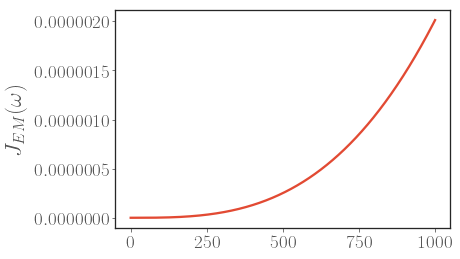

In [8]:
w = np.linspace(0,1000, 10000)
plt.plot(w, J_EM(w, 3))
plt.ylabel(r"$J_{EM}(\omega)$")

### Helper functions to put models together

In [8]:
def build_model(alpha, T_ph, T_EM, N, silent=True, s=3):
    H_model, L_model, A_EM = L_residual(alpha, T_ph, N)
    L_model += L_optical(H_model, A_EM, T_EM, s=s)
    #L_model += EM.L_non_rwa(H_model, A_EM+A_EM.dag(), epsilon, Gamma_EM, T_EM, J_multipolar, principal=False, 
    #                            silent=True, alpha=0., tol=1e-5)
    return H_model, L_model, A_EM


def build_additive_model(alpha, T_ph, T_EM, N, silent=True):
    H_model, L_model, A_EM = L_residual(alpha, T_ph, N)
    A_EM = tensor(sigma, qeye(N))
    L_model += L_additive(A_EM, T_EM)
    return H_model, L_model, A_EM


# $S_{min}(T_{EM})$

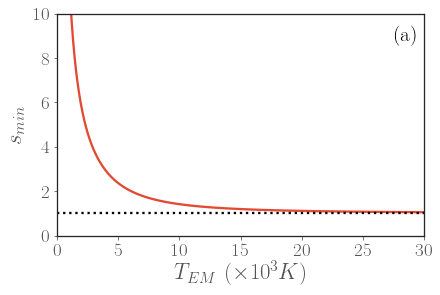

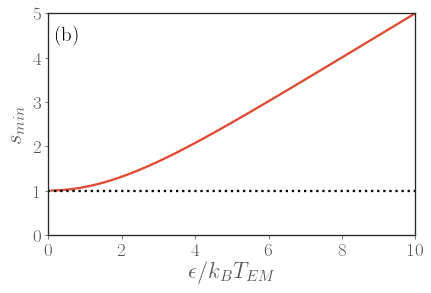

In [34]:

def s_min_as_ratio(x):
    # epsilon/T_EM
    return 0.5*x*float(coth(0.5*x))


def s_min(epsilon, T_EM):
    fac = epsilon/(2*0.695*T_EM)
    return fac*float(coth(fac))


T_EM = np.linspace(1000., 30e3, 1000)

plt.plot(T_EM*1e-3, [s_min(epsilon, t) for t in T_EM])
plt.axhline(1, ls='dotted', color='k')
plt.xlim(0, T_EM[-1]*1e-3)
plt.ylim(0, 10)
plt.xlabel(r"$T_{EM}$ ($\times 10^{3}K$)")
plt.ylabel(r"$s_{min}$")
plt.subplots_adjust(left=0.12, bottom=0.20, right=0.97, top=0.97, wspace=0.24, hspace=0.015)
plt.text(27.5, 8.8, "(a)", color='k', fontsize=21, fontweight='bold')
plt.savefig("thesis-figures/s_min_T.pdf")

plt.figure()
epsilon_over_T_EM = np.linspace(0.1, 10)
plt.plot(epsilon_over_T_EM, [s_min_as_ratio(x) for x in epsilon_over_T_EM])
plt.xlabel(r"$\epsilon/k_B T_{EM}$")
plt.ylabel(r"$s_{min}$")
plt.axhline(1, ls='dotted', color='k')
plt.xlim(0, 10)
plt.ylim(0, 5)
plt.subplots_adjust(left=0.12, bottom=0.20, right=0.97, top=0.97, wspace=0.24, hspace=0.015)
#plt.subplots_adjust(left=0.18, bottom=0.20, right=0.96, top=0.97, wspace=0.24, hspace=0.015)
plt.text(0.18, 4.4, "(b)", color='k', fontsize=21, fontweight='bold')
plt.savefig("thesis-figures/s_min_ratio.pdf")

# Steady-states

In [10]:
def get_steadystate_population(alpha, T_ph, T_EM, N, s=3):
    H_test, L_test, A_EM = build_model(alpha, T_ph, T_EM, N, s=s)
    return (steadystate(H_test, [L_test])*A_EM.dag()*A_EM).tr()

def get_steadystate_population_additive(alpha, T_ph, T_EM, N):
    H_test, L_test, A_EM = build_additive_model(alpha, T_ph, T_EM, N)
    return (steadystate(H_test, [L_test])*A_EM.dag()*A_EM).tr()

def plot_convergence(N_conv, conv_data, alpha_ratio):
    plt.plot(N_conv, conv_data, label=r'$\alpha\epsilon^{-1} = $'+'{}'.format(alpha_ratio))
    plt.xlabel('N')
    plt.ylabel(r'$\rho_e$')
    plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.98, wspace=0.24, hspace=0.015)
    plt.legend()
# test

assert((get_steadystate_population(0., 300., 6000., 6) - thermal_state(6000.))<1e-12)

# Phonon-coupling dependence



In [11]:
alpha_over_epsilons = np.linspace(0.0, 0.1,20)
T_test = 6000.
N = 40
s_vals = [1., 2, s_min(epsilon, T_test), 3]
print(s_vals)

data_6000 = []
for s in s_vals:
    row = []
    for alpha_r in alpha_over_epsilons:
        row.append(get_steadystate_population(alpha_r*epsilon, 300., T_test, N, s=s))
    data_6000.append(row)



[1.0, 2, 2.016718277983244, 3]


In [19]:
save_obj(data_6000, "thesis-data/inversion-pops-T6000K")

In [35]:
alpha_over_epsilons = np.linspace(0.0, 0.1,20)
T_test = 12000.
N = 40
s_vals = [1., s_min(epsilon, T_test), 2, 3]
print(s_vals)

data_12000 = []
for s in s_vals:
    row = []
    for alpha_r in alpha_over_epsilons:
        row.append(get_steadystate_population(alpha_r*epsilon, 300., T_test, N, s=s))
    data_12000.append(row)

[1.0, 1.2938975457009794, 2, 3]


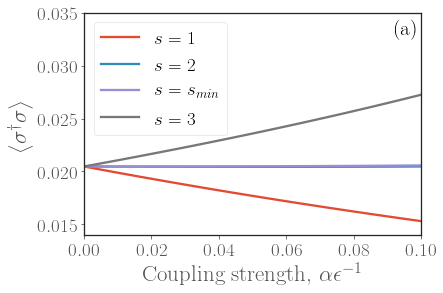

In [18]:
alpha_over_epsilons = np.linspace(0.0, 0.1,20)
plt.plot(alpha_over_epsilons, data_6000[0], label='$s=1$')
plt.plot(alpha_over_epsilons, data_6000[1], label='$s=2$')
plt.plot(alpha_over_epsilons, data_6000[2], label='$s=s_{min}$')
plt.plot(alpha_over_epsilons, data_6000[3], label='$s=3$')
plt.legend()
plt.xlim(0, 0.1)
plt.ylim(0.014, 0.035)
plt.xlabel(r"Coupling strength, $\alpha\epsilon^{-1}$")
plt.ylabel(r'$\expval{\sigma^{\dagger}\sigma}$')
plt.subplots_adjust(left=0.18, bottom=0.20, right=0.96, top=0.97, wspace=0.24, hspace=0.015)
plt.text(0.092, 0.033, "(a)", color='k', fontsize=21, fontweight='bold')
plt.savefig("thesis-figures/population-enhancement-T6000.pdf")

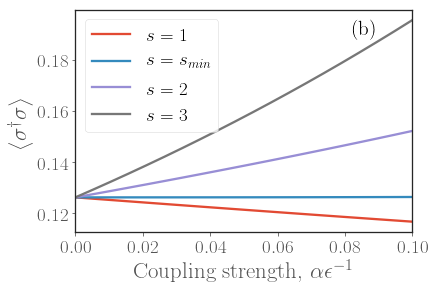

In [38]:
plt.plot(alpha_over_epsilons, data_12000[0], label='$s=1$')
plt.plot(alpha_over_epsilons, data_12000[1], label='$s=s_{min}$')
plt.plot(alpha_over_epsilons, data_12000[2], label='$s=2$')
plt.plot(alpha_over_epsilons, data_12000[3], label='$s=3$')
plt.legend()
plt.xlim(0, 0.1)
plt.xlabel(r"Coupling strength, $\alpha\epsilon^{-1}$")
plt.ylabel(r'$\expval{\sigma^{\dagger}\sigma}$')
#plt.subplots_adjust(left=0.15, bottom=0.20, right=0.96, top=0.97, wspace=0.24, hspace=0.015)
plt.subplots_adjust(left=0.18, bottom=0.20, right=0.96, top=0.97, wspace=0.24, hspace=0.015)
plt.text(0.082, 0.19, "(b)", color='k', fontsize=21, fontweight='bold')
plt.savefig("thesis-figures/population-enhancement-T12000.pdf")

In [36]:
save_obj(data_12000, "thesis-data/inversion-pops-T12000K")